# Introduction

This notebook mainly explores the spacy and textblob nlp libraries in python as applied to the Quora question pairs dataset. First, some phrase modeling is done with gensim and spacy tags the parts of speech in the text it parses, which can be made into a sparse matrix and joined to the original dataframe. The second section creates a similarity score between texts, the 1-similarity number seemed more intuitive so a function was created around spacy's method. Third, textblob generates a sentiment and subjectivity value.

In [128]:
import numpy as np
import pandas as pd
import spacy
import gensim
from bs4 import BeautifulSoup
import re
from collections import Counter

In [129]:
train = pd.read_csv("./input/train.csv.zip")

In [130]:
train.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [131]:
train.shape

(404290, 6)

In [132]:
nlp = spacy.load("en")

## Text cleaning

In [133]:
def clean_text(text):
    
    # Remove HTML
    text = BeautifulSoup(text, "html.parser").get_text()
    
    #removes numbers, symbols, nextline symbols 
    text = re.sub("[^a-zA-Z' ]"," ", str(text))
    text = re.sub("'s", '', text)
    text = text.replace("\n", '').replace('  ', ' ').lower().strip('.')
    text = nlp(text)
    
    #removes punctuation and pronouns, returns lemmatized word
    words=[]
    for word in text:
        if word.pos_ != 'PUNCT' and word.lemma_ != '-PRON-' and not word.is_space:
            words.append(word.lemma_)
    
    #removes stop words
    unigrams=[]
    for word in words:
        if word not in spacy.en.language_data.STOP_WORDS:
            unigrams.append(word)
            
            
    return unigrams

In [134]:

train = train[~train.question2.isnull()]
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## Create bigrams with gensim

In [135]:
question1 = train.question1.apply(clean_text)
question2 = train.question2.apply(clean_text)
bigrams1 = gensim.models.phrases.Phraser(gensim.models.Phrases(question1))
bigrams2 = gensim.models.phrases.Phraser(gensim.models.Phrases(question2))
q1_sents = [bigrams1[question] for question in question1]
q2_sents = [bigrams2[question] for question in question2]

/home/ryeyoo/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [136]:
from collections import Counter
Counter([word for line in q2_sents for word in line]).most_common(10)

[('good', 53286),
 ('india', 14773),
 ('people', 13310),
 ('use', 12402),
 ('like', 11685),
 ('way', 11427),
 ('work', 7892),
 ('time', 7729),
 ('know', 7419),
 ('learn', 7248)]

## Parts of speech in spacy

In [137]:
def pos_count(string, num):
    #counts parts of speech for each spacy document object
    parsed_string = nlp(' '.join(string))
    pos_dict = {}
    
    for word in parsed_string:
        if word.pos_ + str(num) in pos_dict:
            pos_dict[word.pos_ + str(num)] += 1
        else:    
            pos_dict[word.pos_ + str(num)] = 1
    return pos_dict    

In [138]:
print(train['question2'][5])
print(clean_text(train['question2'][5]))
b = pos_count(q2_sents[5], 2)
print(b)


I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?
['triple', 'capricorn', 'sun', 'moon', 'ascendant', 'capricorn']
{'ADJ2': 2, 'NOUN2': 3}


In [139]:


pos_list1 = []
for item in q1_sents[0:1000]:
    pos_dict = pos_count(item, 1)
    pos_list1.append(pos_dict)

pos_list2 = []
for item in q2_sents[0:1000]:
    pos_dict = pos_count(item, 2)
    pos_list2.append(pos_dict)

    

In [140]:
pd.Series({'q1':q1_sents[0:1000]})

q1    [[step_step, guide, invest_share, market, indi...
dtype: object

In [200]:
pos_df1 = pd.DataFrame(pos_list1).fillna(0)
pos_df2 = pd.DataFrame(pos_list2).fillna(0)
train['q1'] = q1_sents
train['q2'] = q2_sents
train_1000 = pd.concat([train[0:1000], pos_df1, pos_df2], axis = 1)

In [201]:
train_1000.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1,q2,ADJ1,ADP1,...,INTJ2,NOUN2,NUM2,PART2,PRON2,PROPN2,PUNCT2,SYM2,VERB2,X2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step_step, guide, invest_share, market, india]","[step_step, guide, invest_share, market]",2.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, kohinoor, koh, noor, diamond]","[happen, indian_government, steal, kohinoor, k...",1.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet_connection, use_vpn]","[internet_speed, increase, hack, dns]",1.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely, solve]","[find, remainder_math, math, divide]",1.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[dissolve_water, quikly, sugar, salt, methane,...","[fish, survive, salt_water]",2.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [169]:
train_1000.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate', 'q1',
       'q2', 'ADJ1', 'ADP1', 'ADV1', 'CCONJ1', 'DET1', 'INTJ1', 'NOUN1',
       'NUM1', 'PART1', 'PRON1', 'PROPN1', 'PUNCT1', 'SYM1', 'VERB1', 'X1',
       'ADJ2', 'ADP2', 'ADV2', 'CCONJ2', 'DET2', 'INTJ2', 'NOUN2', 'NUM2',
       'PART2', 'PRON2', 'PROPN2', 'PUNCT2', 'SYM2', 'VERB2', 'X2'],
      dtype='object')

# Sentence dissimilarity

In [192]:
def dis_similarity(question_pair):
    
    parsed1 = nlp(question_pair[0])
    parsed2 = nlp(question_pair[1])
    anti_sim = 1 - parsed1.similarity(parsed2)
    return anti_sim

In [205]:
train_1000['dis'] = train_1000[['question1','question2']].apply(dis_similarity, axis = 1)


In [206]:
train_1000[['q1', 'q2', 'dis', 'is_duplicate']].groupby('is_duplicate').describe()

dis                                                        \
              count      mean       std           min       25%       50%   
is_duplicate                                                                
0             620.0  0.092791  0.067584 -3.814070e-07  0.044993  0.076624   
1             380.0  0.051181  0.036495 -1.177246e-07  0.025578  0.044578   

                                  
                   75%       max  
is_duplicate                      
0             0.126419  0.425635  
1             0.067796  0.239650

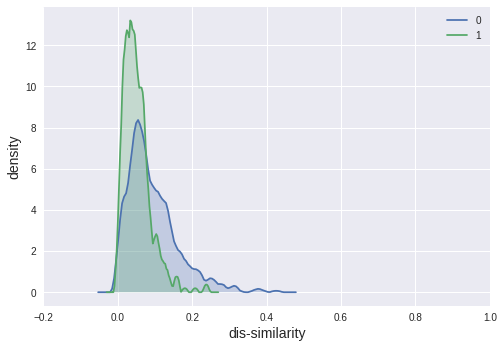

In [209]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for data, label in zip([train_1000['dis'][train_1000['is_duplicate']==0], 
                        train_1000['dis'][train_1000['is_duplicate']==1]], 
                       ["0", "1"]):
    sns.kdeplot(data,  ax=ax, label = label, kernel = 'epa', shade = True)
    
ax.set_xlim([-0.2, 1])
plt.xlabel('dis-similarity', fontsize=14)
plt.ylabel('density', fontsize=14)

plt.show()

## Significant?

In [210]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
log_model = smf.glm('is_duplicate ~ dis', 
        data = train_1000, family = sm.families.Binomial()).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           is_duplicate   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      998
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -595.65
Date:                Fri, 28 Jul 2017   Deviance:                       1191.3
Time:                        14:55:10   Pearson chi2:                 1.00e+03
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6390      0.124      5.173      0.000       0.397       0.881
dis          -16.6059      1.695     -9.798      0.000     -19.928     -13.284
==============================================================================
"""

The low p value from the logistic model indicates it is very unlikely changes in the dissimilarity score are not related to if a question is a duplicate.

# Sentiment

In [151]:
from textblob import TextBlob

def sentiment(question):
    
    pol_sub = [TextBlob(question).sentiment.polarity, 
               TextBlob(question).sentiment.subjectivity]
    return pol_sub           



In [152]:
question1_sent_subj = train_1000['question1'].apply(sentiment)
train_1000['polarity1'], train_1000['subjectivity1'] = zip(*question1_sent_subj)

In [153]:
question1_sent_subj2 = train_1000['question2'].apply(sentiment)
train_1000['polarity2'], train_1000['subjectivity2'] = zip(*question1_sent_subj2)

In [154]:
train_1000.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1,q2,ADJ1,ADP1,...,PROPN2,PUNCT2,SYM2,VERB2,X2,dis,polarity1,subjectivity1,polarity2,subjectivity2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step_step, guide, invest_share, market, india]","[step_step, guide, invest_share, market]",2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.092445e-08,0.00,0.00,0.0,0.0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, kohinoor, koh, noor, diamond]","[happen, indian_government, steal, kohinoor, k...",1.0,0.0,...,0.0,0.0,0.0,3.0,0.0,2.660413e-01,0.00,0.00,0.0,0.0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet_connection, use_vpn]","[internet_speed, increase, hack, dns]",1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,2.873536e-01,0.00,0.00,0.0,0.0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely, solve]","[find, remainder_math, math, divide]",1.0,0.0,...,0.0,0.0,0.0,2.0,0.0,4.087173e-01,-0.13,0.91,0.0,0.0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[dissolve_water, quikly, sugar, salt, methane,...","[fish, survive, salt_water]",2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,5.502849e-01,0.00,0.00,0.0,0.0


In [155]:
train_1000['pol_diff'] = train_1000['polarity1'] - train_1000['polarity2']
train_1000['subj_diff'] = train_1000['subjectivity1'] - train_1000['subjectivity2']

In [156]:
train_1000[['pol_diff', 'subj_diff', 'is_duplicate']].groupby('is_duplicate').describe()

pol_diff                                                    \
                count      mean       std  min       25%  50%  75%  max   
is_duplicate                                                              
0               620.0 -0.020985  0.294470 -1.0 -0.038542  0.0  0.0  1.5   
1               380.0  0.005836  0.257705 -1.0  0.000000  0.0  0.0  1.0   

             subj_diff                                                         
                 count      mean       std  min       25%  50%       75%  max  
is_duplicate                                                                   
0                620.0  0.004383  0.344923 -1.0 -0.095052  0.0  0.027083  1.0  
1                380.0  0.019755  0.273195 -1.0  0.000000  0.0  0.000000  1.0

In [157]:
log_model = smf.glm('is_duplicate ~ pol_diff * subj_diff', 
        data = train_1000, family = sm.families.Binomial()).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           is_duplicate   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      996
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -662.80
Date:                Fri, 28 Jul 2017   Deviance:                       1325.6
Time:                        14:41:04   Pearson chi2:                 1.00e+03
No. Iterations:                     4                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.4930      0.066     -7.449      0.000      -0.623      -0.363
pol_diff               0.3103      0.241      1.289      0.197      -0.161       0.782
subj_diff              0.0905      0.212      0.427      0.669      -0.325       0.506
pol_diff:subj_diff     0.2171      0.468      0.464      0.642      -0.699       1.133
======================================================================================
"""

# Counting different words

In [158]:
print(train_1000['question1'].iloc[30])
print(train_1000['question2'].iloc[30])

What's one thing you would like to do better?
What's one thing you do despite knowing better?


In [159]:
def different_words(question_pair):
    
    parsed1 = question_pair[0]
    parsed2 = question_pair[1]
    diff1 = [word for word in parsed1 if word not in parsed2]
    diff2 = [word for word in parsed2 if word not in parsed1]
    return len((diff1 + diff2))
    #return diff1 + diff2

In [160]:
test = train_1000[['question1', 'question2']].iloc[100]

In [161]:
print(different_words(test))
print(test[0])
print(test[1])

8
Will there really be any war between India and Pakistan over the Uri attack? What will be its effects?
Will there be a nuclear war between India and Pakistan?


In [162]:
diff_lens = train_1000[['q1', 'q2']].apply(different_words, axis = 1)

In [163]:
train_1000['num_unmatched_words'] = diff_lens
train_1000.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1,q2,ADJ1,ADP1,...,VERB2,X2,dis,polarity1,subjectivity1,polarity2,subjectivity2,pol_diff,subj_diff,num_unmatched_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step_step, guide, invest_share, market, india]","[step_step, guide, invest_share, market]",2.0,0.0,...,0.0,0.0,5.092445e-08,0.00,0.00,0.0,0.0,0.00,0.00,1
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, kohinoor, koh, noor, diamond]","[happen, indian_government, steal, kohinoor, k...",1.0,0.0,...,3.0,0.0,2.660413e-01,0.00,0.00,0.0,0.0,0.00,0.00,4
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet_connection, use_vpn]","[internet_speed, increase, hack, dns]",1.0,0.0,...,1.0,0.0,2.873536e-01,0.00,0.00,0.0,0.0,0.00,0.00,6
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely, solve]","[find, remainder_math, math, divide]",1.0,0.0,...,2.0,0.0,4.087173e-01,-0.13,0.91,0.0,0.0,-0.13,0.91,7
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[dissolve_water, quikly, sugar, salt, methane,...","[fish, survive, salt_water]",2.0,0.0,...,1.0,0.0,5.502849e-01,0.00,0.00,0.0,0.0,0.00,0.00,11


In [164]:
train_1000[['is_duplicate', 'num_unmatched_words']].groupby('is_duplicate').describe()

num_unmatched_words                                              
                           count      mean       std  min  25%  50%  75%   max
is_duplicate                                                                  
0                          620.0  5.906452  4.583911  0.0  2.0  5.0  8.0  23.0
1                          380.0  3.005263  2.623212  0.0  1.0  2.0  4.0  13.0

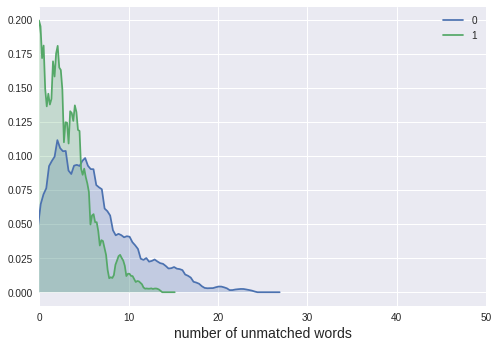

In [165]:
fig, ax = plt.subplots()

for num, label in zip([train_1000['num_unmatched_words'][train_1000['is_duplicate']==0], 
                       train_1000['num_unmatched_words'][train_1000['is_duplicate']==1]], 
                      ['0','1']):
    sns.kdeplot(num,  ax=ax, label = label, kernel = 'epa', shade = True)

ax.set_xlim([0, 50])
plt.xlabel("number of unmatched words", fontsize = 14)
plt.show()
 

In [166]:
log_model = smf.glm('is_duplicate ~ num_unmatched_words', 
                    data = train_1000, family = sm.families.Binomial()).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           is_duplicate   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      998
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -596.67
Date:                Fri, 28 Jul 2017   Deviance:                       1193.3
Time:                        14:41:04   Pearson chi2:                     967.
No. Iterations:                     5                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.4702      0.109      4.296      0.000       0.256       0.685
num_unmatched_words    -0.2278      0.023     -9.892      0.000      -0.273      -0.183
=======================================================================================
"""